In [1]:
from tqdm import tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("행정동_월별_배출량.csv",encoding = "cp949")

In [4]:
df

,emd_nm,y_m,em_g
0,외도동,2018-01,95864700
1,외도동,2018-02,88582050
2,외도동,2018-03,97356250
3,외도동,2018-04,88844750
4,외도동,2018-05,94064300
...,...,...,...
1671,한경면,2021-02,17276700
1672,한경면,2021-03,21007400
1673,한경면,2021-04,22908150
1674,한경면,2021-05,26927600


### 성능 비교용 데이터셋 생성

In [5]:
train_df = df.loc[df["y_m"] < "2021-04"]

In [6]:
test_df = df.loc[df["y_m"] >= "2021-04"]

In [7]:
temp = pd.DataFrame(data= test_df["emd_nm"].unique())
temp.rename(columns = {0 : "emd_nm"},inplace=True)

for i in test_df["y_m"].unique():
    temp = pd.merge(temp,df.loc[df["y_m"] == i,["emd_nm","em_g"]],how="right",on = "emd_nm")
    temp.rename(columns = {"em_g" : i},inplace=True)
temp.to_csv("행정동_월별_배출량_2021_04.csv",encoding = "cp949",index = False)

In [8]:
temp

,emd_nm,2021-04,2021-05,2021-06
0,외도동,89457350,97421950,100096900
1,아라동,94682900,107045700,112190800
2,노형동,212851000,227061100,239069250
3,도두동,17377150,19663550,19733350
4,오라동,51424200,57321800,58187300
5,삼양동,84829840,93122870,96172500
6,이도2동,192527200,215882550,225423200
7,일도2동,131462200,147183350,147438200
8,건입동,35386850,38047500,36493300
9,화북동,99636900,109316800,110750050


### 날짜 지정 범위 생성과 시리즈 객체 변환

In [9]:
# 데이터프레임을 Series로 변환하는 함수
def time_series(df, i):
    # 행정동별로 데이터를 뽑습니다.
    location = df[df['emd_nm']==i]
    ## 날짜 지정 범위는 시작 월부터 2021년 5월 전까지 기준
    index = pd.date_range(min(location['y_m']),'2021-04',freq='BM') 
    ## 시리즈 객체로 변환
    ts = pd.Series(location['em_g'].values,index=index)
    return ts

## 탐색적 데이터 분석
### 행정동별 매출 특성
#### 계절성이 있는 행정동

adf - test는 통계학에서 실행하는 가설 검정의 절차를 따른다.
- 귀무가설:시계열 자료가 정상 시계열이 아니다.
- 대립 가설: 시계열 자료가 정상성을 만족한다.

pmdarima 패키지에 있는 ADFTest클래스 import

p-value 0.05보다 낮으면 대립가설이 채택 -> 정상시계열이다. -> 차분이 필요하지 않다.

0.05보다 높으면 귀무가설이 채택 -> 정상시계열이 아니다 -> 차분이 필요하다.

In [10]:
new_df = train_df

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 274.67it/s]


<AxesSubplot:>

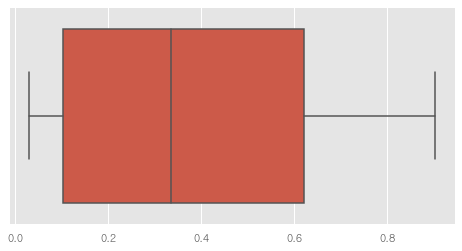

In [11]:
from pmdarima.arima import ADFTest
## ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]

adf_p = []
count = 0
skipped = []

for i in tqdm(new_df['emd_nm'].unique()):
    ts = time_series(new_df,i)
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)

plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

In [12]:
# p-value가 0.05보다 작은 행정동의 개수
print(count)

5


In [13]:
# ADF-Test 오류 행정동 개수
if skipped:
    print(f"WarningCount: {len(skipped)}, store_id_list:{skipped}")

42개의 행정동중 5개를 제외한 37개의 행정동이 정상시계열이 아니다.

## 모델 구축과 검증
### 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [14]:
#!pip install tzlocal

In [15]:
# import rpy2
# from rpy2.robjects.packages import importr # rpy2 내의 패키지를 불러올 importr 클래스

# utils = importr('utils') # utils 패키지를 임포트
# utils.install_packages('forecast') # r의 forecast 패키지 설치.
# utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

### 시계열 모델 선택과 검증
#### 1. 자기회귀누적이동평균 모델(ARIMA)

In [16]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('em_g') # em_g 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)# str 형식으로 정의된 auto_arima
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

loc_name = []
final_pred1 = []
final_pred2 = []
final_pred3 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(location['em_g'], start=c(start_year, start_month), frequency=12) 
    # 자동회귀누적이동평균 model
    forecast = auto_arima(train)
    # 3개월 예상, final_pred에 추가
    loc_name.append(i)
    final_pred1.append(pandas2ri.ri2py(forecast).values[0])
    final_pred2.append(pandas2ri.ri2py(forecast).values[1])
    final_pred3.append(pandas2ri.ri2py(forecast).values[2])
    print(i,np.array(pandas2ri.ri2py(forecast).values))

  2%|█▉                                                                                 | 1/42 [00:01<01:05,  1.60s/it]

외도동 [[84893533.80947447]
 [92014593.45666127]
 [90137546.02054177]]


  7%|█████▉                                                                             | 3/42 [00:02<00:37,  1.03it/s]

아라동 [[9.95446602e+07]
 [1.10694729e+08]
 [1.05399967e+08]]
노형동 [[2.18951305e+08]
 [2.32767632e+08]
 [2.25583058e+08]]


 12%|█████████▉                                                                         | 5/42 [00:03<00:28,  1.29it/s]

도두동 [[16083648.79755872]
 [17565761.59760864]
 [17946925.27239759]]
오라동 [[51289802.60598852]
 [58050681.62702025]
 [60028648.5646284 ]]


 17%|█████████████▊                                                                     | 7/42 [00:04<00:21,  1.61it/s]

삼양동 [[80831886.81395541]
 [93640383.5747817 ]
 [91380129.01525098]]
이도2동 [[1.67660925e+08]
 [1.93390420e+08]
 [1.86933972e+08]]


 19%|███████████████▊                                                                   | 8/42 [00:04<00:17,  1.94it/s]

일도2동 [[1.15034912e+08]
 [1.28583312e+08]
 [1.18235362e+08]]


 24%|███████████████████▌                                                              | 10/42 [00:05<00:15,  2.13it/s]

건입동 [[29181228.23125161]
 [33455828.2312516 ]
 [32795728.2312516 ]]
화북동 [[9.51071344e+07]
 [1.11418066e+08]
 [1.12684119e+08]]


 29%|███████████████████████▍                                                          | 12/42 [00:06<00:13,  2.21it/s]

봉개동 [[12260368.63578491]
 [13776684.19673446]
 [14344438.56898575]]
삼도1동 [[43038209.30906738]
 [49238309.30906738]
 [45153264.30906737]]


 33%|███████████████████████████▎                                                      | 14/42 [00:06<00:09,  2.89it/s]

이도1동 [[32889599.99999999]
 [38228249.99999999]
 [33045149.99999999]]
용담2동 [[50256549.51305522]
 [55490999.51305523]
 [51534699.51305524]]


 38%|███████████████████████████████▏                                                  | 16/42 [00:07<00:10,  2.47it/s]

연동 [[1.65625077e+08]
 [1.82498386e+08]
 [1.75568267e+08]]
이호동 [[17132759.34921785]
 [20668201.25162677]
 [18455044.93015027]]
애월읍

 43%|███████████████████████████████████▏                                              | 18/42 [00:08<00:09,  2.61it/s]

 [[92433675.]
 [94605200.]
 [96776725.]]
동홍동 [[1.02309810e+08]
 [1.03521097e+08]
 [1.04714226e+08]]


 48%|███████████████████████████████████████                                           | 20/42 [00:09<00:06,  3.52it/s]

대정읍 [[1.07673048e+08]
 [1.09468995e+08]
 [1.11264942e+08]]
영천동 [[44995500.]
 [44995500.]
 [44995500.]]


 52%|██████████████████████████████████████████▉                                       | 22/42 [00:09<00:05,  3.74it/s]

서홍동 [[43109200.98354382]
 [42943942.09350942]
 [42761807.68645506]]
효돈동 [[25566366.15722655]
 [24436994.77868333]
 [23439773.54182623]]


 55%|████████████████████████████████████████████▉                                     | 23/42 [00:09<00:04,  4.14it/s]

중문동 [[60028350.]
 [60028350.]
 [60028350.]]


 60%|████████████████████████████████████████████████▊                                 | 25/42 [00:10<00:04,  3.71it/s]

대륜동 [[44887390.74858073]
 [48574319.11411371]
 [47825232.12163225]]
남원읍 [[62602150.]
 [62602150.]
 [62602150.]]


 67%|██████████████████████████████████████████████████████▋                           | 28/42 [00:11<00:04,  3.11it/s]

대천동 [[56643687.45897054]
 [67991646.53537306]
 [71532507.73333164]]
안덕면 [[39037393.92213345]
 [43279902.45070916]
 [45469528.98432195]]
천지동 [[32440864.98925843]
 [32115966.02366189]
 [31917129.48522157]]


 69%|████████████████████████████████████████████████████████▌                         | 29/42 [00:11<00:04,  2.95it/s]

예래동 [[15213054.2282749 ]
 [16315501.89530934]
 [21637261.38121747]]


 71%|██████████████████████████████████████████████████████████▌                       | 30/42 [00:12<00:03,  3.11it/s]

표선면 [[34559363.57005568]
 [37227838.39863282]
 [41905954.55658974]]


 81%|██████████████████████████████████████████████████████████████████▍               | 34/42 [00:12<00:02,  3.82it/s]

알수없음 [[2223482.32399813]
 [2223482.32399813]
 [2223482.32399813]]
성산읍 [[60014350.]
 [60014350.]
 [60014350.]]
정방동 [[23088069.56977754]
 [23056382.02009745]
 [23035144.88667875]]
송산동 [[23350296.69713417]
 [25928951.25434956]
 [27193475.95141774]]


 86%|██████████████████████████████████████████████████████████████████████▎           | 36/42 [00:13<00:02,  2.93it/s]

중앙동 [[45578799.0878263 ]
 [45672502.93518642]
 [45740253.49699482]]
삼도2동 [[23964728.96082114]
 [28927087.73343848]
 [31240703.94970306]]


 88%|████████████████████████████████████████████████████████████████████████▏         | 37/42 [00:14<00:01,  2.84it/s]

일도1동 [[16085320.07235716]
 [15964961.37952516]
 [15844602.68669316]]


 95%|██████████████████████████████████████████████████████████████████████████████    | 40/42 [00:14<00:00,  4.21it/s]

용담1동 [[20082964.32320655]
 [24407951.09185757]
 [23167436.39996343]]
조천읍 [[59529200.]
 [59529200.]
 [59529200.]]
구좌읍 [[30919350.]
 [30919350.]
 [30919350.]]
한림읍 [[69780550.]
 [69780550.]
 [69780550.]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:14<00:00,  2.88it/s]

한경면 [[21007400.]
 [21007400.]
 [21007400.]]


In [17]:
#4월 예측값
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
외도동,8.489353e+07
아라동,9.954466e+07
노형동,2.189513e+08
도두동,1.608365e+07
오라동,5.128980e+07
삼양동,8.083189e+07
이도2동,1.676609e+08
일도2동,1.150349e+08
건입동,2.918123e+07
화북동,9.510713e+07


In [18]:
#5월 예측값
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
외도동,9.201459e+07
아라동,1.106947e+08
노형동,2.327676e+08
도두동,1.756576e+07
오라동,5.805068e+07
삼양동,9.364038e+07
이도2동,1.933904e+08
일도2동,1.285833e+08
건입동,3.345583e+07
화북동,1.114181e+08


In [19]:
#6월 예측값
data_df3 = pd.DataFrame(data = final_pred3,index = loc_name)
data_df3

,0
외도동,9.013755e+07
아라동,1.054000e+08
노형동,2.255831e+08
도두동,1.794693e+07
오라동,6.002865e+07
삼양동,9.138013e+07
이도2동,1.869340e+08
일도2동,1.182354e+08
건입동,3.279573e+07
화북동,1.126841e+08


In [20]:
# ARIMA를 활용한 4,5,6월 예측 데이터프레임 생성
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-04","0_y" : "2021-05"},inplace=True)
final = pd.merge(final,data_df3,how = "left",on = final.행정동명)
final = final.drop("key_0",axis = 1)
final.rename(columns = {0:"2021-06"},inplace=True)
final

,행정동명,2021-04,2021-05,2021-06
0,외도동,8.489353e+07,9.201459e+07,9.013755e+07
1,아라동,9.954466e+07,1.106947e+08,1.054000e+08
2,노형동,2.189513e+08,2.327676e+08,2.255831e+08
3,도두동,1.608365e+07,1.756576e+07,1.794693e+07
4,오라동,5.128980e+07,5.805068e+07,6.002865e+07
5,삼양동,8.083189e+07,9.364038e+07,9.138013e+07
6,이도2동,1.676609e+08,1.933904e+08,1.869340e+08
7,일도2동,1.150349e+08,1.285833e+08,1.182354e+08
8,건입동,2.918123e+07,3.345583e+07,3.279573e+07
9,화북동,9.510713e+07,1.114181e+08,1.126841e+08


In [21]:
final.to_csv("final_1_2021456.csv",encoding = "cp949",index=False)

#### 지수평활법

In [22]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('em_g') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets 
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

loc_name = []
final_pred1 = []
final_pred2 = []
final_pred3 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(location['em_g'], start=c(start_year, start_month), frequency=12) 
    # 지수평활법 model
    forecast = ets(train)
    # 3개월 예상값, final_pred에 추가
    loc_name.append(i)
    final_pred1.append(pandas2ri.ri2py(forecast).values[0])
    final_pred2.append(pandas2ri.ri2py(forecast).values[1])
    final_pred3.append(pandas2ri.ri2py(forecast).values[2])
    print(i,np.array(pandas2ri.ri2py(forecast).values))

  2%|█▉                                                                                 | 1/42 [00:00<00:20,  1.99it/s]

외도동 [[87174852.27080067]
 [93087256.8444881 ]
 [93247819.82043226]]


  7%|█████▉                                                                             | 3/42 [00:01<00:18,  2.08it/s]

아라동 [[1.03950141e+08]
 [1.14746906e+08]
 [1.14090460e+08]]
노형동 [[2.27157087e+08]
 [2.38977224e+08]
 [2.42072950e+08]]


 10%|███████▉                                                                           | 4/42 [00:01<00:17,  2.13it/s]

도두동 [[15539211.21971884]
 [17264706.77666835]
 [17398695.28315141]]


 12%|█████████▉                                                                         | 5/42 [00:02<00:16,  2.22it/s]

오라동 [[52869879.87912866]
 [56936021.5159065 ]
 [60334973.67950378]]


 14%|███████████▊                                                                       | 6/42 [00:02<00:16,  2.22it/s]

삼양동 [[77338428.80633053]
 [87276349.03970344]
 [85641217.91401659]]


 17%|█████████████▊                                                                     | 7/42 [00:03<00:15,  2.25it/s]

이도2동 [[1.89884596e+08]
 [2.02684975e+08]
 [2.08237901e+08]]


 21%|█████████████████▊                                                                 | 9/42 [00:03<00:14,  2.30it/s]

일도2동 [[1.22420323e+08]
 [1.30737193e+08]
 [1.34690080e+08]]
건입동 [[29618801.80011652]
 [32179962.6053163 ]
 [32490762.28165858]]


 24%|███████████████████▌                                                              | 10/42 [00:04<00:13,  2.36it/s]

화북동 [[9.32765337e+07]
 [1.00979845e+08]
 [1.03432184e+08]]


 26%|█████████████████████▍                                                            | 11/42 [00:04<00:12,  2.40it/s]

봉개동 [[12652784.55886332]
 [13340721.43032964]
 [13367241.58100004]]
삼도1동 

 29%|███████████████████████▍                                                          | 12/42 [00:05<00:12,  2.33it/s]

[[44784437.64956181]
 [46390702.07584149]
 [45573125.00914048]]


 36%|█████████████████████████████▎                                                    | 15/42 [00:06<00:11,  2.29it/s]

이도1동 [[34180881.74079572]
 [38074749.30678172]
 [37988920.33950484]]
용담2동 [[50307383.23371612]
 [53750483.33411279]
 [53526533.0259467 ]]
연동 [[1.68899404e+08]
 [1.80591788e+08]
 [1.78608171e+08]]


 38%|███████████████████████████████▏                                                  | 16/42 [00:06<00:11,  2.30it/s]

이호동 [[17812092.60150301]
 [19588243.6186288 ]
 [19914046.95614525]]


 43%|███████████████████████████████████▏                                              | 18/42 [00:07<00:10,  2.29it/s]

애월읍 [[9.69406626e+07]
 [1.02284315e+08]
 [1.06559241e+08]]
동홍동 [[1.01916569e+08]
 [1.01916569e+08]
 [1.01916569e+08]]


 48%|███████████████████████████████████████                                           | 20/42 [00:08<00:09,  2.38it/s]

대정읍 [[1.07372939e+08]
 [1.09416157e+08]
 [1.11459375e+08]]
영천동 [[44552047.39471767]
 [44552047.39471767]
 [44552047.39471767]]


 52%|██████████████████████████████████████████▉                                       | 22/42 [00:09<00:08,  2.36it/s]

서홍동 [[43048493.930845]
 [43048493.930845]
 [43048493.930845]]
효돈동 [[26845328.18580095]
 [26845328.18580095]
 [26845328.18580095]]


 55%|████████████████████████████████████████████▉                                     | 23/42 [00:09<00:07,  2.41it/s]

중문동 [[60027806.64608315]
 [60027806.64608315]
 [60027806.64608315]]


 57%|██████████████████████████████████████████████▊                                   | 24/42 [00:10<00:07,  2.42it/s]

대륜동 [[45509343.44144981]
 [45509343.44144981]
 [45509343.44144981]]


 60%|████████████████████████████████████████████████▊                                 | 25/42 [00:10<00:07,  2.41it/s]

남원읍 [[62601507.32087947]
 [62601507.32087947]
 [62601507.32087947]]


 62%|██████████████████████████████████████████████████▊                               | 26/42 [00:11<00:06,  2.43it/s]

대천동 [[59315857.61378794]
 [59315857.61378794]
 [59315857.61378794]]


 64%|████████████████████████████████████████████████████▋                             | 27/42 [00:11<00:06,  2.49it/s]

안덕면 [[39450203.54158856]
 [39450203.54158856]
 [39450203.54158856]]


 67%|██████████████████████████████████████████████████████▋                           | 28/42 [00:11<00:05,  2.51it/s]

천지동 [[31777964.82829031]
 [31777964.82829031]
 [31777964.82829031]]


 71%|██████████████████████████████████████████████████████████▌                       | 30/42 [00:12<00:04,  2.50it/s]

예래동 [[17300426.50142905]
 [17300426.50142905]
 [17300426.50142905]]
표선면 [[34066584.87775268]
 [34066584.87775268]
 [34066584.87775268]]


 76%|██████████████████████████████████████████████████████████████▍                   | 32/42 [00:13<00:04,  2.49it/s]

알수없음 [[2153783.11159438]
 [2153783.11159438]
 [2153783.11159438]]
성산읍 [[59607515.09162527]
 [59607515.09162527]
 [59607515.09162527]]


 79%|████████████████████████████████████████████████████████████████▍                 | 33/42 [00:13<00:03,  2.44it/s]

정방동 [[23135052.66942503]
 [23135052.66942503]
 [23135052.66942503]]


 81%|██████████████████████████████████████████████████████████████████▍               | 34/42 [00:14<00:03,  2.44it/s]

송산동 [[20041713.96577217]
 [20041713.96577217]
 [20041713.96577217]]


 83%|████████████████████████████████████████████████████████████████████▎             | 35/42 [00:14<00:02,  2.45it/s]

중앙동 [[45293053.71195993]
 [45293053.71195993]
 [45293053.71195993]]
삼도2동

 86%|██████████████████████████████████████████████████████████████████████▎           | 36/42 [00:15<00:02,  2.46it/s]

 [[25172376.36873215]
 [27649614.23687689]
 [31252330.38836759]]


 90%|██████████████████████████████████████████████████████████████████████████▏       | 38/42 [00:15<00:01,  2.52it/s]

일도1동 [[16315630.39743951]
 [16315630.39743951]
 [16315630.39743951]]
용담1동 [[22124230.41506654]
 [21959254.0445857 ]
 [21206763.04168923]]


 95%|██████████████████████████████████████████████████████████████████████████████    | 40/42 [00:16<00:00,  3.78it/s]

조천읍 [[62389029.31384887]
 [65249326.22647905]
 [68109623.13910922]]
구좌읍 [[32300011.32511281]
 [33775587.11432596]
 [35251162.9035391 ]]
한림읍

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:16<00:00,  2.54it/s]

 [[67826426.43117933]
 [68674308.07903588]
 [69522189.72689244]]
한경면 [[20644328.03563642]
 [21118544.55799725]
 [21592761.08035808]]


In [23]:
#4월 예측값
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
외도동,8.717485e+07
아라동,1.039501e+08
노형동,2.271571e+08
도두동,1.553921e+07
오라동,5.286988e+07
삼양동,7.733843e+07
이도2동,1.898846e+08
일도2동,1.224203e+08
건입동,2.961880e+07
화북동,9.327653e+07


In [24]:
#5월 예측값
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
외도동,9.308726e+07
아라동,1.147469e+08
노형동,2.389772e+08
도두동,1.726471e+07
오라동,5.693602e+07
삼양동,8.727635e+07
이도2동,2.026850e+08
일도2동,1.307372e+08
건입동,3.217996e+07
화북동,1.009798e+08


In [25]:
#6월 예측값
data_df3 = pd.DataFrame(data = final_pred3,index = loc_name)
data_df3

,0
외도동,9.324782e+07
아라동,1.140905e+08
노형동,2.420729e+08
도두동,1.739870e+07
오라동,6.033497e+07
삼양동,8.564122e+07
이도2동,2.082379e+08
일도2동,1.346901e+08
건입동,3.249076e+07
화북동,1.034322e+08


In [26]:
# 지수평활법을 활용한 4,5,6월 예측 데이터프레임 생성
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-04","0_y" : "2021-05"},inplace=True)
final = pd.merge(final,data_df3,how = "left",on = final.행정동명)
final = final.drop("key_0",axis = 1)
final.rename(columns = {0:"2021-06"},inplace=True)
final

,행정동명,2021-04,2021-05,2021-06
0,외도동,8.717485e+07,9.308726e+07,9.324782e+07
1,아라동,1.039501e+08,1.147469e+08,1.140905e+08
2,노형동,2.271571e+08,2.389772e+08,2.420729e+08
3,도두동,1.553921e+07,1.726471e+07,1.739870e+07
4,오라동,5.286988e+07,5.693602e+07,6.033497e+07
5,삼양동,7.733843e+07,8.727635e+07,8.564122e+07
6,이도2동,1.898846e+08,2.026850e+08,2.082379e+08
7,일도2동,1.224203e+08,1.307372e+08,1.346901e+08
8,건입동,2.961880e+07,3.217996e+07,3.249076e+07
9,화북동,9.327653e+07,1.009798e+08,1.034322e+08


In [27]:
# 예측 데이터셋 정리
final.to_csv("final_2_2021456.csv",encoding = "cp949",index=False)

#### 3. STL 분해를 적용한 지수평활법

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# location = time_series(new_df, "구좌읍")
# # STL 분해
# stl = seasonal_decompose(new_df.em_g, freq=12)
# stl.plot()
# plt.show()

In [29]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# pandas2ri를 활성화 
pandas2ri.activate()
stlm = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = stlm(ts, s.window="periodic", method='ets') # STL 분해 후 지수평활법을 통한 예측 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r을 파이썬에서 사용 가능
stlm = robjects.r(stlm)# str 형식으로 정의된 stlm
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

loc_name = []
final_pred1 = []
final_pred2 = []
final_pred3 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    data_len = len(location)
    
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(location['em_g'], start=c(start_year, start_month), frequency=12) 
    # STL 분해를 적용한 지수평활 model
    if data_len > 24:
        forecast = stlm(train)
    # 지수평활 model
    else:
        forecast = ets(train)  
    # 3개월 예측값, final_pred에 추가
    loc_name.append(i)
    final_pred1.append(pandas2ri.ri2py(forecast).values[0])
    final_pred2.append(pandas2ri.ri2py(forecast).values[1])
    final_pred3.append(pandas2ri.ri2py(forecast).values[2])
    print(i,np.array(pandas2ri.ri2py(forecast).values))


 29%|███████████████████████▍                                                          | 12/42 [00:00<00:00, 52.48it/s]

외도동 [[85056673.89059277]
 [91755641.7526222 ]
 [92120542.36171003]]
아라동 [[1.02044619e+08]
 [1.13044366e+08]
 [1.11446659e+08]]
노형동 [[2.23110254e+08]
 [2.38889714e+08]
 [2.39203597e+08]]
도두동 [[15898091.18188749]
 [17256336.4307851 ]
 [17720718.2332201 ]]
오라동 [[51372876.44087081]
 [55779324.84405911]
 [58154402.94679532]]
삼양동 [[77782965.68517551]
 [85937822.87594652]
 [86566735.26456672]]
이도2동 [[1.80151753e+08]
 [1.95911262e+08]
 [2.03544946e+08]]
일도2동 [[1.19961767e+08]
 [1.29149199e+08]
 [1.33006975e+08]]
건입동 [[28776901.54438335]
 [32128001.72158113]
 [33274801.30954733]]
화북동 [[8.95977026e+07]
 [9.80889269e+07]
 [1.02486766e+08]]
봉개동 [[12666493.50100587]
 [13253737.06003027]
 [13326692.49371009]]
삼도1동 [[43594369.39438158]
 [45924821.14121666]
 [46156696.55777197]]
이도1동 [[32490740.40517807]
 [36172669.92805726]
 [36790609.69637304]]
용담2동 [[50072289.54928352]
 [53631335.1143288 ]
 [54376581.3578983 ]]


 57%|██████████████████████████████████████████████▊                                   | 24/42 [00:00<00:00, 52.38it/s]

연동 [[1.70497675e+08]
 [1.83543080e+08]
 [1.82312060e+08]]
이호동 [[17762037.04666245]
 [19470275.88661582]
 [19546028.35875276]]
애월읍 [[87675095.03589267]
 [90804089.94401146]
 [88839065.3328251 ]]
동홍동 [[8.63869930e+07]
 [1.08321127e+08]
 [1.18234227e+08]]
대정읍 [[1.00372913e+08]
 [1.08549425e+08]
 [1.06449750e+08]]
영천동 [[42294220.04319378]
 [45567774.1788292 ]
 [45822375.02675965]]
서홍동 [[38124842.04031327]
 [47872614.36626656]
 [50233337.54036354]]
효돈동 [[24902959.83279046]
 [26260832.08422187]
 [23255484.61300696]]
중문동 [[54139797.74512961]
 [61070911.97087919]
 [71192611.86709186]]
대륜동 [[40697954.48039701]
 [46976585.27476336]
 [46230431.83940779]]


 69%|████████████████████████████████████████████████████████▌                         | 29/42 [00:00<00:00, 51.49it/s]

남원읍 [[57608106.26299088]
 [68178386.99660164]
 [72020828.22196327]]
대천동 [[53139416.65930454]
 [59401898.0907018 ]
 [60982361.52289882]]
안덕면 [[37049561.47942683]
 [39456652.27055785]
 [40221669.50601792]]
천지동 [[26460578.66788867]
 [34186660.423927  ]
 [36433484.36604492]]
예래동 [[15937891.05494288]
 [17566977.22068408]
 [20475958.66127037]]
표선면 [[33544637.09499433]
 [37580680.94929716]
 [39843413.94597425]]
알수없음 [[2408617.40391692]
 [2875259.39451462]
 [3465458.21199617]]
성산읍 [[59733470.96922149]
 [61979799.62572373]
 [62518690.67694344]]
정방동 [[20061112.72859229]
 [24986776.95169084]
 [26394936.79077183]]
송산동 [[20834156.89055356]
 [28774187.10626695]
 [30274454.44348948]]


 83%|████████████████████████████████████████████████████████████████████▎             | 35/42 [00:00<00:00, 51.97it/s]

중앙동 [[40062665.91670886]
 [45128008.55601906]
 [42650820.05641101]]
삼도2동 [[24631266.94702433]
 [26823159.85313764]
 [30313253.75089815]]
일도1동 [[15405050.92860529]
 [16352599.52760572]
 [16326465.85926413]]
용담1동 [[22213409.85913133]
 [22930610.72682346]
 [22790362.12431522]]


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.45it/s]

조천읍 [[62389029.31384887]
 [65249326.22647905]
 [68109623.13910922]]
구좌읍 [[32300011.32511281]
 [33775587.11432596]
 [35251162.9035391 ]]
한림읍 [[67826426.43117933]
 [68674308.07903588]
 [69522189.72689244]]
한경면 [[20644328.03563642]
 [21118544.55799725]
 [21592761.08035808]]


In [30]:
# 4월 예측데이터
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
외도동,8.505667e+07
아라동,1.020446e+08
노형동,2.231103e+08
도두동,1.589809e+07
오라동,5.137288e+07
삼양동,7.778297e+07
이도2동,1.801518e+08
일도2동,1.199618e+08
건입동,2.877690e+07
화북동,8.959770e+07


In [31]:
# 5월 예측데이터
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
외도동,9.175564e+07
아라동,1.130444e+08
노형동,2.388897e+08
도두동,1.725634e+07
오라동,5.577932e+07
삼양동,8.593782e+07
이도2동,1.959113e+08
일도2동,1.291492e+08
건입동,3.212800e+07
화북동,9.808893e+07


In [32]:
# 6월 예측데이터
data_df3 = pd.DataFrame(data = final_pred3,index = loc_name)
data_df3

,0
외도동,9.212054e+07
아라동,1.114467e+08
노형동,2.392036e+08
도두동,1.772072e+07
오라동,5.815440e+07
삼양동,8.656674e+07
이도2동,2.035449e+08
일도2동,1.330070e+08
건입동,3.327480e+07
화북동,1.024868e+08


In [33]:
# STL 분해를 적용한 지수평활법 4,5,6 예측 데이터 생성
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-04","0_y" : "2021-05"},inplace=True)
final = pd.merge(final,data_df3,how = "left",on = final.행정동명)
final = final.drop("key_0",axis = 1)
final.rename(columns = {0:"2021-06"},inplace=True)
final

,행정동명,2021-04,2021-05,2021-06
0,외도동,8.505667e+07,9.175564e+07,9.212054e+07
1,아라동,1.020446e+08,1.130444e+08,1.114467e+08
2,노형동,2.231103e+08,2.388897e+08,2.392036e+08
3,도두동,1.589809e+07,1.725634e+07,1.772072e+07
4,오라동,5.137288e+07,5.577932e+07,5.815440e+07
5,삼양동,7.778297e+07,8.593782e+07,8.656674e+07
6,이도2동,1.801518e+08,1.959113e+08,2.035449e+08
7,일도2동,1.199618e+08,1.291492e+08,1.330070e+08
8,건입동,2.877690e+07,3.212800e+07,3.327480e+07
9,화북동,8.959770e+07,9.808893e+07,1.024868e+08


In [34]:
final.to_csv("final_3_2021456.csv",encoding = "cp949",index=False)

## 성능 비교

In [35]:
#실제 배출량 값 로드
df = pd.read_csv("행정동_월별_배출량_2021_04.csv",encoding = "cp949")
#각 모델을 활용한 배출량 값 로드
df1 = pd.read_csv("final_1_2021456.csv",encoding = "cp949")
df2 = pd.read_csv("final_2_2021456.csv",encoding = "cp949")
df3 = pd.read_csv("final_3_2021456.csv",encoding = "cp949")

In [36]:
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
import numpy as np

In [37]:
# 성능 비교를 위해 지표 함수 생성
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [38]:
print("Arima 결과")
print()
print("4월")
regression_results(df["2021-04"], df1["2021-04"])
print()
print("5월")
regression_results(df["2021-05"], df1["2021-05"])
print()
print("6월")
regression_results(df["2021-06"], df1["2021-06"])

Arima 결과

4월
explained_variance:  0.9847
mean_squared_log_error:  0.0108
r2:  0.9832
MAE:  3987276.2568
MSE:  36435347931968.59
RMSE:  6036169.9721

5월
explained_variance:  0.9831
mean_squared_log_error:  0.0155
r2:  0.9825
MAE:  4962305.9055
MSE:  46426419659430.18
RMSE:  6813693.5402

6월
explained_variance:  0.96
mean_squared_log_error:  0.0412
r2:  0.9556
MAE:  7946285.146
MSE:  128826441983080.75
RMSE:  11350173.6543


In [39]:
print("지수평활법 결과")
print()
print("4월")
regression_results(df["2021-04"], df2["2021-04"])
print()
print("5월")
regression_results(df["2021-05"], df2["2021-05"])
print()
print("6월")
regression_results(df["2021-06"], df2["2021-06"])

지수평활법 결과

4월
explained_variance:  0.989
mean_squared_log_error:  0.0083
r2:  0.989
MAE:  3805073.4789
MSE:  23940945742115.367
RMSE:  4892948.5734

5월
explained_variance:  0.9846
mean_squared_log_error:  0.0197
r2:  0.9835
MAE:  5257164.0597
MSE:  43779745147747.17
RMSE:  6616626.4174

6월
explained_variance:  0.9758
mean_squared_log_error:  0.0461
r2:  0.9736
MAE:  6747606.7807
MSE:  76699742122353.55
RMSE:  8757838.8957


In [40]:
print("STL분해를 적용한 지수평활법 결과")
print()
print("4월")
regression_results(df["2021-04"], df3["2021-04"])
print()
print("5월")
regression_results(df["2021-05"], df3["2021-05"])
print()
print("6월")
regression_results(df["2021-06"], df3["2021-06"])

STL분해를 적용한 지수평활법 결과

4월
explained_variance:  0.9909
mean_squared_log_error:  0.0116
r2:  0.9869
MAE:  4251519.5825
MSE:  28513011778558.715
RMSE:  5339757.6517

5월
explained_variance:  0.9772
mean_squared_log_error:  0.0242
r2:  0.9764
MAE:  6330630.8862
MSE:  62655925301383.46
RMSE:  7915549.5893

6월
explained_variance:  0.9654
mean_squared_log_error:  0.0504
r2:  0.9645
MAE:  7459888.4979
MSE:  102976521315940.67
RMSE:  10147734.7874
